# Import 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import qutip as qt
from copy import deepcopy
import scipy as sp


import experiments as meas
from experiments.MM_dual_rail_base import MM_dual_rail_base
from fitting.fit_display_classes import GeneralFitting
from fitting.wigner import WignerAnalysis

from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

user = "seb"
print("Welcome", user)


station = MultimodeStation(
    user=user,
    experiment_name = "250119_qec",
)

active_reset_dict = {
    'active_reset': True, # on recalibration of readout, turn off active reset because it will be wrong for selecting when to apply the qubit pulse
    'ef_reset': True,
    'storage_reset': False,
    'coupler_reset': False,
    'pre_selection_reset': True,
    'man_reset': False, 
    'use_qubit_man_reset': True, # whether to use the qubit
    'pre_selection_parity':True,
}


USE_QUEUE = True
mm_base_calib = MM_dual_rail_base(station.hardware_cfg, station.soc)

Importing all classes from  D:\python\multimode_expts\experiments\dual_rail
Importing all classes from  D:\python\multimode_expts\experiments\qsim
Importing all classes from  D:\python\multimode_expts\experiments\qubit_cavity
Importing all classes from  D:\python\multimode_expts\experiments\single_qubit
Skipped top-level files ['characterization_runner.py', 'dataset.py', 'MM_base.py', 'MM_dual_rail_base.py', 'MM_rb_base.py', 'mock_hardware.py', 'sequential_experiment.py', 'sequential_experiment_classes.py', 'station.py', 'sweep_runner.py']
Server status: healthy
Pending jobs: 0
Welcome seb
[STATION] Using main hardware_config version: CFG-HW-20260219-00004
[STATION] Using main multiphoton_config version: CFG-MP-20260121-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260220-00031
[STATION] Using main floquet_storage_swap version: CFG-FL-20260219-00009
Data, plots, logs will be stored in: D:\experiments\250119_qec
Hardware configs will be read from D:\python\multimode_exp

# Calibrate single shot 

In [2]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
singleshot_defaults = AttrDict(dict(    
    reps=5000,
    relax_delay=500,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    qubits=[0],
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values



def singleshot_postproc(station, expt):
    expt.analyze(plot=False, station=station, subdir=station.autocalib_path)
    fids = expt.data['fids']
    confusion_matrix = expt.data['confusion_matrix']
    thresholds_new = expt.data['thresholds']
    angle = expt.data['angle']
    print(fids)

    hardware_cfg = station.hardware_cfg
    hardware_cfg.device.readout.phase = [hardware_cfg.device.readout.phase[0] + angle]
    hardware_cfg.device.readout.threshold = thresholds_new
    hardware_cfg.device.readout.threshold_list = [thresholds_new]
    hardware_cfg.device.readout.Ie = [np.median(expt.data['Ie_rot'])]
    hardware_cfg.device.readout.Ig = [np.median(expt.data['Ig_rot'])]
    if expt.cfg.expt.active_reset:
        hardware_cfg.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        hardware_cfg.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

    expt.display(station)


single_shot_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.HistogramExperiment,
    default_expt_cfg = singleshot_defaults,
    postprocessor = singleshot_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

Job submitted: JOB-20260220-00420 (queue position: 1)

[0.1s] Job JOB-20260220-00420: pending

[96.5s] Job JOB-20260220-00420: running
[WORKER] Loading HistogramExperiment from experiments.single_qubit.single_shot
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260220-00420_HistogramExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 66%|████████████████████████▏            | 3276/5000 [00:08<00:04, 399.36it/s]
[127.0s] Job JOB-20260220-00420: completed
100%|█████████████████████████████████████| 5000/5000 [00:12<00:00, 399.59it/s]
Unrotated:
Ig -506.3486486486487 +/- 73.32034414512448 	 Qg 18.905405405405403 +/- 95.75964893463107 	 Amp g 506.7014587919156
Ie -217.72297297297297 +/- 95.47189852338343 	 Qe -375.77162162162165 +/- 96.72363830342287 	 Amp e 434.2897702874581
Rotated:
Ig -319.29871736359837 +/- 95.45509073565843 	 Qg -400.12013942808437 +/- 73.

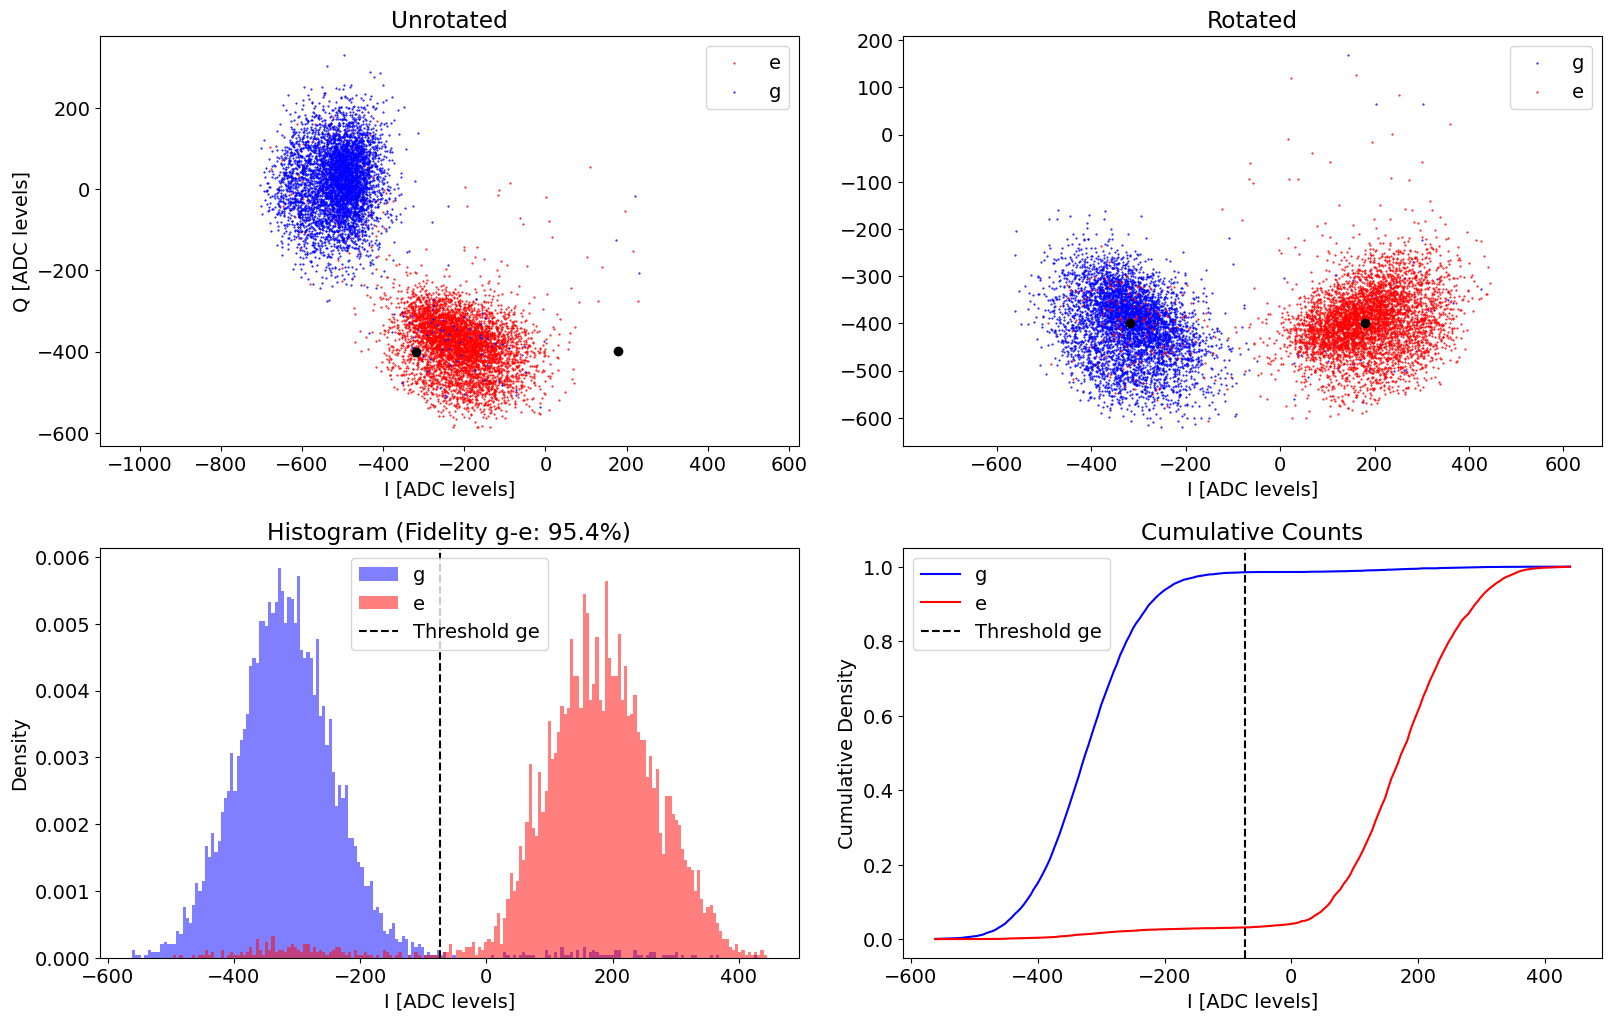

Plot saved to D:\experiments\250119_qec\plots\2026-02-20_09-41-43_histogram.png
Plot reference appended to D:\experiments\250119_qec\logs\2026-02-20.md
ge fidelity (%): 95.39999999999995
rotation angle (deg): 53.82214991547305
threshold ge: -73.77842578668759


In [3]:
single_shot = single_shot_runner.execute(
        go_kwargs=dict(analyze=False, display=False),
        check_f=False,
        relax_delay=2500,
        gate_based=False,
        # **active_reset_dict,
    )

# Calibrate the beam splitter 

In [4]:
from joint_parity_calibrator import JointParityCalibrator
calibrator = JointParityCalibrator(station, client, use_queue=USE_QUEUE, debug=True)

In [ ]:

# Run calibration and fit (one call does everything)
lookup_result = calibrator.calibrate_bs_rate_lookup_table(
    man_mode_no=1,
    stor_mode_no=6,
    qubit_states=('g','e'),
    num_pts=11,
    reps=50,
    degree_rate=4,
    degree_freq=4,
    freq_span_initial=0.13,
    freq_span_final=0.075,
    gain_span_frac=0.2,
    n_pulses=6,
    length_range_frac=(0.90, 1.2),

)

[JointParityCalibrator] === Building BS rate lookup table ===
[JointParityCalibrator]   Gain range: 10634.2 to 14178.9
[JointParityCalibrator]   Length range: 1.6240 to 2.1654 us
[JointParityCalibrator] 
--- Calibrating for qubit in |g> (11 points) ---
[JointParityCalibrator] 
  Point 1/11: gain=10634.2, length=2.1654 us, freq_guess=1248.7177 MHz
[JointParityCalibrator]     Step 1/3: Frequency error amp
[JointParityCalibrator]   Running error amp (frequency) for qubit in |g>...
Job submitted: JOB-20260220-00421 (queue position: 1)

[0.1s] Job JOB-20260220-00421: pending

[2.1s] Job JOB-20260220-00421: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260220-00421_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'

In [ ]:
# If the fit doesn't look good, refit with different polynomial degrees (no re-running experiments):
# calibrator.fit_bs_rate_lookup_table(lookup_result, degree_rate=3, degree_freq=5)

station.ds_storage.get_bs_rate_coeffs('M1-S2')

In [ ]:
station.snapshot_man1_storage_swap(update_main=True)

# Calibrate the flat top pi pulse length 

### First calibrate the pi pulse gain for a given length and flat top sigma.

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
amprabi_defaults = AttrDict(dict(
    start=0,
    step=60,
    expts=151,
    reps=200,
    rounds=1,
    sigma_test=0.1,
    qubit=0,
    pulse_type='flat_top',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    postpulse=False, 
    if_ef=False,  # If true, will check ef frequency and update it
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def amprabi_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    # Copied over but what's all this below????
    # Which ones are actually used? 
    # Can we straighten out all the nested boolean logic???
    pulse_ge = station.hardware_cfg.device.qubit.pulses.pi_ge
    if expt_cfg.sigma_test is None:
        expt_cfg.sigma_test = pulse_ge.sigma[0]
    if expt_cfg.step is None:
        expt_cfg.step = int(pulse_ge.gain[0] / (expt_cfg.expts - 1))
    
    expt_cfg.checkEF = False
    expt_cfg.pulse_ge_init = False
    expt_cfg.pulse_ge_after = False
    if expt_cfg.if_ef:
        expt_cfg.checkEF = True
        expt_cfg.pulse_ge_init = True
        expt_cfg.pulse_ge_after = True
    
    return expt_cfg

def amprabi_postproc(station, expt):
    station.hardware_cfg.device.qubit.pulses.pi_ge.gain = [expt.data['pi_gain_avgi']]
    station.hardware_cfg.device.qubit.pulses.hpi_ge.gain = [expt.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')

In [ ]:
# Execute
# =================================
amprabi_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.AmplitudeRabiExperiment,
    default_expt_cfg = amprabi_defaults,
    # preprocessor = amprabi_preproc,
    # postprocessor = amprabi_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [ ]:
N_qubit = 1 # number of 2pi rotation on the qubit 
N_bs = 3 # number of 2pi rotation on the beam splitter
man_mode_no = 1
chi_ge = station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
# g_bs_guess = np.abs(chi_ge) * ((N_bs**2 - N_qubit**2) / (4*N_qubit**2 - 1))**1/2
# Tp = 1 / np.abs(chi_ge) * (4*N_qubit**2 - 1)** 1/2 * (1 - 1/(4*N_bs**2))**(-1/2)

g_bs_guess = np.sqrt(3)/2*chi_ge
Tp = np.pi/(4*g_bs_guess)

print(f"Initial guess for beam-splitter rate: {g_bs_guess:.4f} MHz")
print(f"Initial guess for beam-splitter pulse length: {Tp:.4f} us")

gain_qb_pi_pulse = station.hardware_cfg.device.qubit.pulses.pi_ge.gain[0]
sigma_qb_pi_pulse = station.hardware_cfg.device.qubit.pulses.pi_ge.sigma[0]
pi_pulse_type = station.hardware_cfg.device.qubit.pulses.pi_ge.type[0]
assert pi_pulse_type == 'gauss', "Only gaussian pi pulse is supported for now"
n=4 # assume the pulse is 4 sigma long
theta_to_gain = np.pi/2/gain_qb_pi_pulse
drive_to_gain_qb = sigma_qb_pi_pulse * np.sqrt(np.pi)/theta_to_gain * sp.special.erf(n/2)
length_to_gain = drive_to_gain_qb / 4

sigma_flat_top = 0.025
nb_point = 1

length_vec = np.linspace(1, 1, 1)*Tp
gain_guess = int(length_to_gain/min(length_vec)*8)
gain_vec = np.zeros(len(length_vec))
print("Length vec:", length_vec)
print('gain guess', gain_guess)

In [ ]:
expts = 100 
step = gain_guess//expts

for idx, length in enumerate(length_vec):
    try:
        print(f"Length: {length}")
        amprabi = amprabi_runner.execute(
            go_kwargs=dict(analyze=True, display=True),
            flat_length=length,
            sigma_test=sigma_flat_top,
            step = step, 
            expts = expts,
            start=10,
        )

        gain_fit = amprabi.data['pi_gain_avgi']
        gain_vec[idx] = gain_fit
        print(f"Fitted gain: {gain_fit}")

        if USE_QUEUE:
            amprabi.display()

    except Exception as e:
        print(f"Error at length {length}: {e}")
        gain_vec[idx] = np.nan  # Mark this point as NaN to indicate failure
    

In [ ]:
fig, ax = plt.subplots()
ax.plot(length_vec, gain_vec, marker='o')
ax.set_xlabel('Pulse Length (us)')
ax.set_ylabel('Fitted Gain')
ax.set_title('Fitted Gain vs Pulse Length')


### Then do the photon number resolved spectroscopy

In [ ]:
photon_number_spectro_defaults = AttrDict(dict(
    start=3560, 
    step=0.1,
    expts=200,
    reps=2000,
    rounds=1,
    length=1,
    gain=400,
    sigma=0.1,
    qubits=[0],
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,
))

photon_number_spectro_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment,
    default_expt_cfg=photon_number_spectro_defaults,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [ ]:
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=1)
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
print(f"pre_sweep_pulse: {pre_sweep_pulse}")

In [ ]:
span = 1
expt = 100
step = span / expt
start = station.hardware_cfg.device.qubit.f_ge[0] - span*0.8
length = 15


for idx, length in enumerate(length_vec):

    try:
        photon_number_spectro_g = photon_number_spectro_runner.execute(
            go_kwargs=dict(analyze=True, display=True, save=True),
            pre_sweep_pulse=pre_sweep_pulse,
            prepulse=False,
            gate_based=False,
            start=start,
            length=length,
            sigma=sigma_flat_top,
            gain=int(gain_vec[idx]),
            step=step,
            expts=expt,
            relax_delay=500,
        )

        if USE_QUEUE:
            photon_number_spectro_g.display()

        photon_number_spectro_e = photon_number_spectro_runner.execute(
        go_kwargs=dict(analyze=True, display=True, save=True),
        pre_sweep_pulse=pre_sweep_pulse,
        prepulse=True,
        gate_based=False,
        start=start,
        length=length,
        sigma=sigma_flat_top,
        gain=int(gain_vec[idx]),
        step=step,
        expts=expt,
        relax_delay=500,
        )

        if USE_QUEUE:
            photon_number_spectro_e.display()




    except Exception as e:
        print(f"Error at length {length}: {e}")


In [ ]:
x_g = photon_number_spectro_g.data['xpts']
x_e = photon_number_spectro_e.data['xpts']
y_g =  photon_number_spectro_g.data['avgi']
y_e =  photon_number_spectro_e.data['avgi']
diff = np.abs(y_g - y_e)

fig, ax = plt.subplots()
ax.plot(x_g, y_g, '-o', label='Qubit in $|g\\rangle$', color='tab:blue')
ax.plot(x_e, y_e, '-o', label='Qubit in $|e\\rangle$', color='tab:red')


In [ ]:
old_gain = station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.gain[0]
old_sigma = station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.sigma[0]
old_length = station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.length[0]

station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.gain[0] = int(gain_fit)
station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.sigma[0] = sigma_flat_top
station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.length[0] = length_vec[0]

In [ ]:
station.preview_config_update()
station.snapshot_hardware_config(update_main=True)

# Calibrate the joint parity measurement 

In [4]:
from joint_parity_calibrator import JointParityCalibrator
calibrator = JointParityCalibrator(station, client, use_queue=USE_QUEUE, debug=True)

In [ ]:
man_mode_no = 1
stor_mode_no = 6
stor_name = f'M1-S{stor_mode_no}'
chi_ge = station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]

# # Frequency guess from joint parity if already calibrated
# jp_params = station.ds_storage.get_joint_parity(stor_name)  # [freq_bs, gain, length, wait_time]
# if jp_params is not None:
#     f_bs_g_guess = jp_params[0] + np.abs(chi_ge) / 2
#     f_bs_e_guess = jp_params[0] - np.abs(chi_ge) / 2
#     print(f"Freq guess from JP: f_bs={jp_params[0]:.4f}, f_g={f_bs_g_guess:.4f}, f_e={f_bs_e_guess:.4f}")
# else:
#     f_bs_g_guess = None
#     f_bs_e_guess = None
#     print("No existing JP calibration, will use lookup table for freq guess")

# # Rate guess
# existing_coeffs = station.ds_storage.get_bs_rate_coeffs(stor_name, qubit_state='g')
# if existing_coeffs is not None and jp_params is not None:
#     g_bs_guess = station.ds_storage.get_bs_rate_at_gain(stor_name, jp_params[1], qubit_state='g')
#     print(f"Using existing bs_rate from ds_storage at JP gain={jp_params[1]}: {g_bs_guess:.4f} MHz")
# else:
#     g_bs_guess = np.sqrt(3)/2 * np.abs(chi_ge) * 0.5
#     print(f"Using analytical guess from chi_ge")
g_bs_guess = np.sqrt(3)/2 * np.abs(chi_ge) * 0.5
rate_list = g_bs_guess * np.linspace(.9, 1.20, 15)
print(f"Chi_ge: {chi_ge:.4f} MHz")
print(f"Initial guess for beam-splitter rate: {g_bs_guess:.4f} MHz")
print(f"Testing beam-splitter rates around: {rate_list}")


Chi_ge: 0.2802 MHz
Initial guess for beam-splitter rate: 0.1213 MHz
Testing beam-splitter rates around: [0.12133766 0.12588782 0.13043799 0.13498815 0.13953831]


[JointParityCalibrator] === ALICE: Sweeping 5 beam splitter rates ===
[JointParityCalibrator] 
Rate 1/5: g_bs=0.1213 MHz
[JointParityCalibrator] === ALICE: Calibrating at g_bs=0.1213 MHz ===
[JointParityCalibrator]   Initial: gain=11229, length_bs=2.0604 us
[JointParityCalibrator]   Freq guesses: f_bs_g=1248.7338, f_bs_e=1249.0018 (override=no)
[JointParityCalibrator]   Running error amp for qubit in |g>...
    Temporarily setting storage parameters: freq=1248.7338 MHz, gain=11229, pi_length=2.0604 us
storage is:  M1-S6


D:\python\multimode_expts\experiments\dataset.py:507: UserWarning: No solution within valid gain range [11640.692403341805, 15928.775729656274] for M1-S6 (e state). Returning closest root: 11293.2
  warnings.warn(
D:\python\multimode_expts\experiments\dataset.py:507: UserWarning: No solution within valid gain range [11587.4457394014, 14061.209194915531] for M1-S6 (g state). Returning closest root: 11164.5
  warnings.warn(
D:\python\multimode_expts\experiments\dataset.py:451: UserWarning: Gain 11229 is outside valid range [11587.4457394014, 14061.209194915531] for M1-S6 (g state)
  warnings.warn(
D:\python\multimode_expts\experiments\dataset.py:451: UserWarning: Gain 11229 is outside valid range [11640.692403341805, 15928.775729656274] for M1-S6 (e state)
  warnings.warn(


Job submitted: JOB-20260219-00749 (queue position: 1)

[0.1s] Job JOB-20260219-00749: pending

[2.3s] Job JOB-20260219-00749: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00749_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'g', 'man_mode_no': 1, 'stor_mode_no': 6, 'parameter_to_test': 'frequency', 'span': 0.05, 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S6', 'pi', 0], 'start': 1248.7088230333286, 'step': 0.0010204081632653062}
100%|█████████████████████████████████

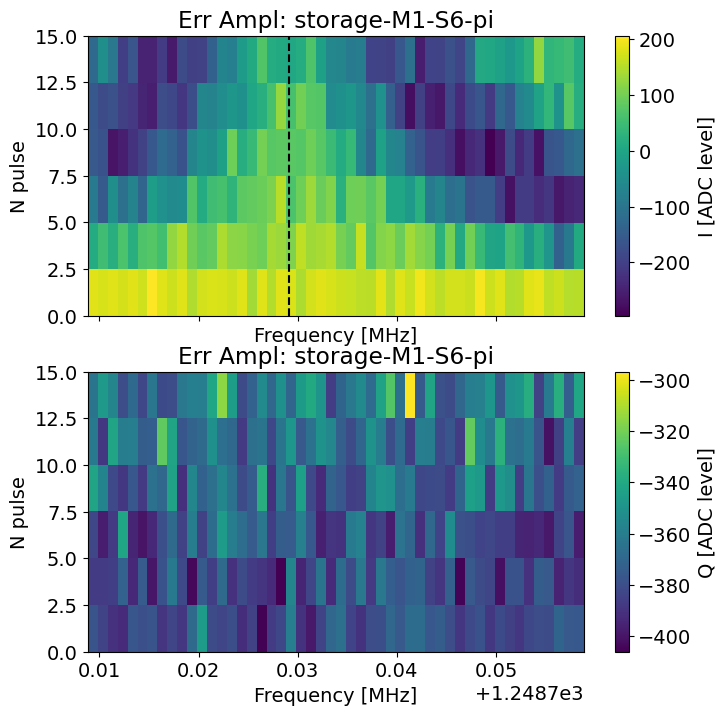

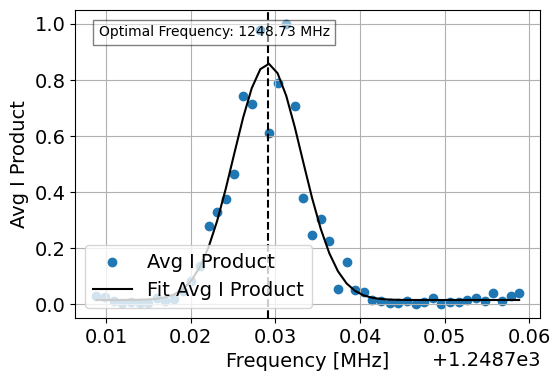

[JointParityCalibrator]     Optimal frequency: 1248.7291 MHz
[JointParityCalibrator]   Running error amp for qubit in |e>...
    Temporarily setting storage parameters: freq=1249.0018 MHz, gain=11229, pi_length=2.0604 us
storage is:  M1-S6
Job submitted: JOB-20260219-00750 (queue position: 1)

[0.1s] Job JOB-20260219-00750: pending

[2.1s] Job JOB-20260219-00750: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00750_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'man_mode_no': 1, 'stor_

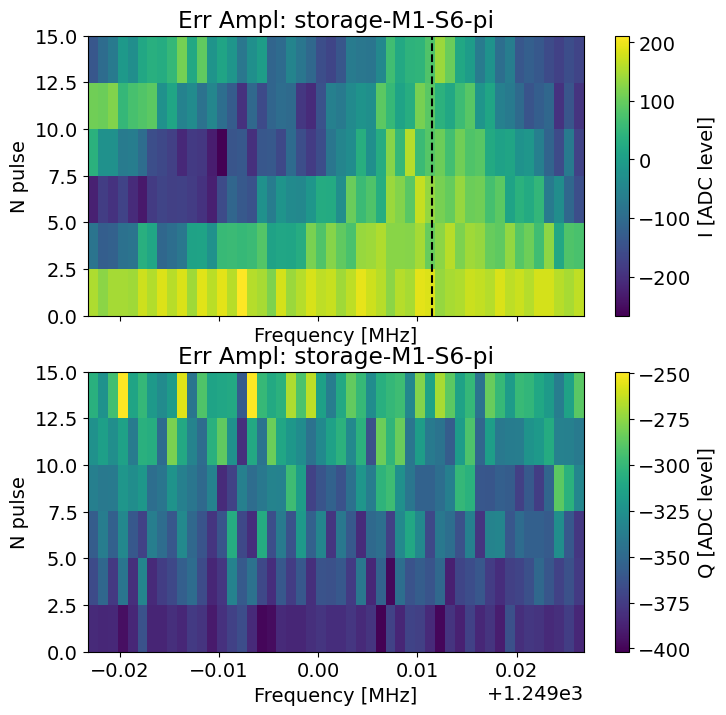

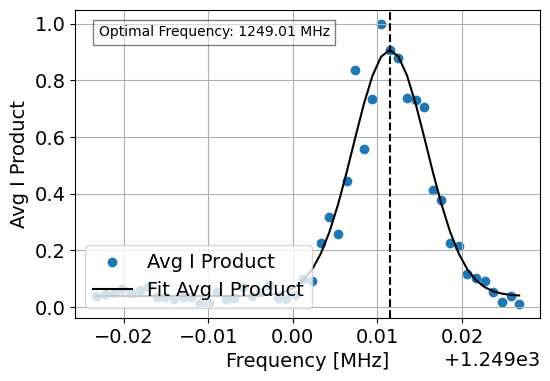

[JointParityCalibrator]     Optimal frequency: 1249.0115 MHz
[JointParityCalibrator]   Calibrated freq_bs=1248.8703 MHz
[JointParityCalibrator]   Running Rabi confirmation (run_both_states=False)...
Job submitted: JOB-20260219-00752 (queue position: 1)

[0.1s] Job JOB-20260219-00752: pending

[24.8s] Job JOB-20260219-00752: running
[WORKER] Loading SidebandGeneralExperiment from experiments.single_qubit.sideband_general
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00752_SidebandGeneralExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 94%|██████████████████████████████████████▌  | 94/100 [00:36<00:02,  2.57it/s]Using RF channel: 1

[88.2s] Job JOB-20260219-00752: completed
100%|████████████████████████████████████████| 100/100 [00:39<00:00,  2.56it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00752_SidebandGeneralExperiment.h5
[WORKER] S

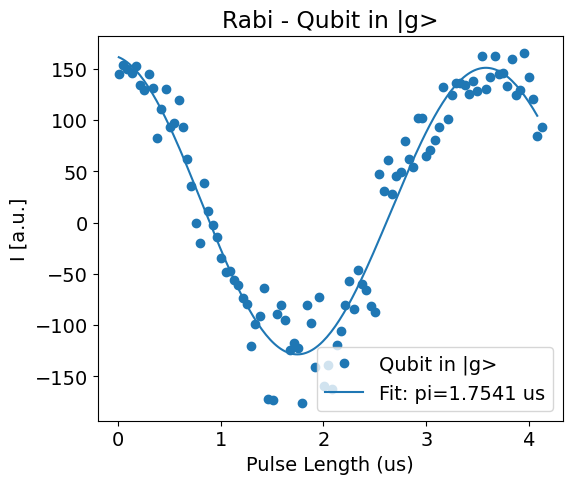

[JointParityCalibrator]     Extracted pi_length: 1.7541 us
[JointParityCalibrator]   Calibrated pi_length=1.7541 us
[JointParityCalibrator]   Running ALICE Wigner for qubit in |g>...
Job submitted: JOB-20260219-00754 (queue position: 1)

[0.1s] Job JOB-20260219-00754: pending

[24.3s] Job JOB-20260219-00754: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00754_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 90%|█████████████████████████████████████▊    | 45/50 [00:18<00:02,  2.22it/s]
[67.5s] Job JOB-20260219-00754: completed
100%|██████████████████████████████████████████| 50/50 [00:20<00:00,  2.50it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00754_WignerTomography1ModeExperiment.h5
[WORKER] Saving

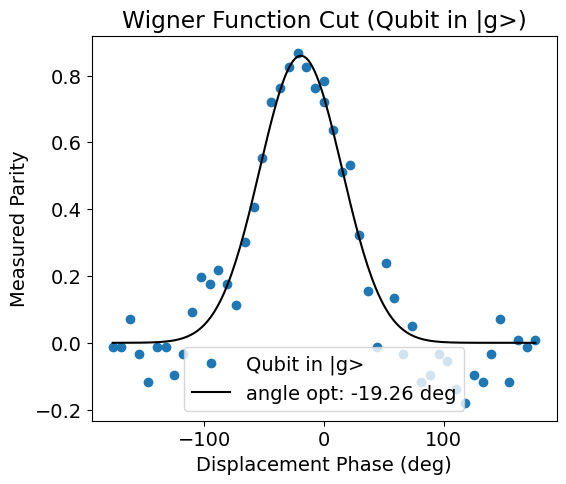

[JointParityCalibrator]     Theta: -19.26 deg
[JointParityCalibrator]   Running ALICE Wigner for qubit in |e>...
Job submitted: JOB-20260219-00755 (queue position: 1)

[0.1s] Job JOB-20260219-00755: pending

[2.2s] Job JOB-20260219-00755: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00755_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 88%|████████████████████████████████████▉     | 44/50 [00:18<00:02,  2.21it/s]
[26.7s] Job JOB-20260219-00755: completed
100%|██████████████████████████████████████████| 50/50 [00:20<00:00,  2.44it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00755_WignerTomography1ModeExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260219-00755

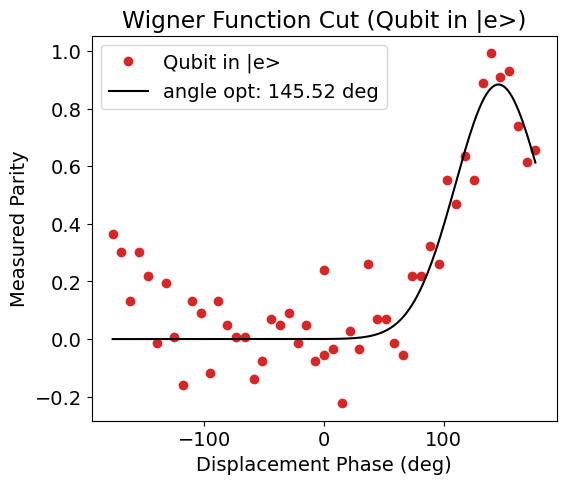

[JointParityCalibrator]     Theta: 145.52 deg
[JointParityCalibrator]   theta_g=-19.26 deg, theta_e=145.52 deg
[JointParityCalibrator]   Phase difference: 0.9154 pi
[JointParityCalibrator] 
Rate 2/5: g_bs=0.1259 MHz
[JointParityCalibrator] === ALICE: Calibrating at g_bs=0.1259 MHz ===
[JointParityCalibrator]   Initial: gain=11615, length_bs=1.9859 us
[JointParityCalibrator]   Freq guesses: f_bs_g=1248.7291, f_bs_e=1249.0115 (override=yes)
[JointParityCalibrator]   Running error amp for qubit in |g>...
    Temporarily setting storage parameters: freq=1248.7291 MHz, gain=11615, pi_length=1.9859 us
storage is:  M1-S6
Job submitted: JOB-20260219-00756 (queue position: 1)


D:\python\multimode_expts\experiments\dataset.py:507: UserWarning: No solution within valid gain range [11587.4457394014, 14061.209194915531] for M1-S6 (g state). Returning closest root: 11586.3
  warnings.warn(



[0.1s] Job JOB-20260219-00756: pending

[2.1s] Job JOB-20260219-00756: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00756_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'g', 'man_mode_no': 1, 'stor_mode_no': 6, 'parameter_to_test': 'frequency', 'span': 0.05, 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S6', 'pi', 0], 'start': 1248.70408840897, 'step': 0.0010204081632653062}
 83%|████████████████████████████████████▋       | 5/6 [00:32<00:06,  6.48s/it]pulse_to_test: 

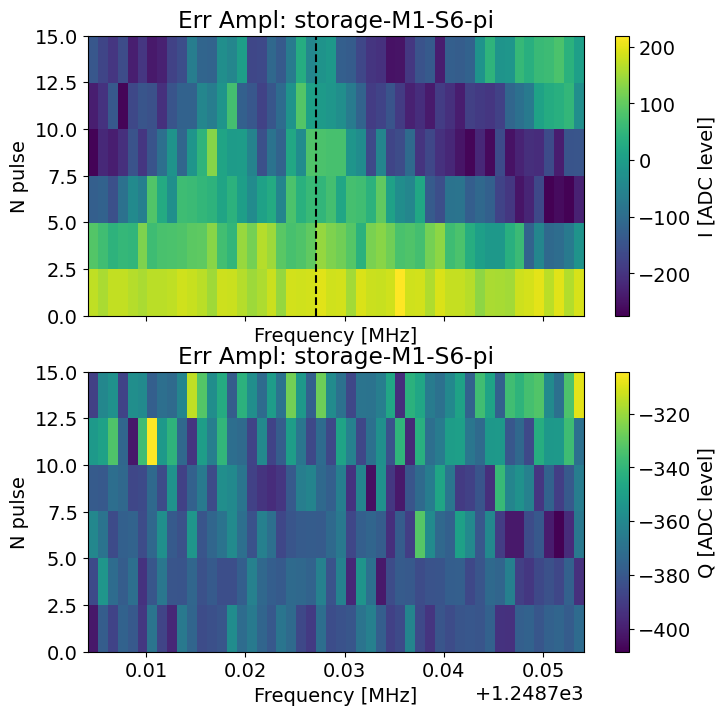

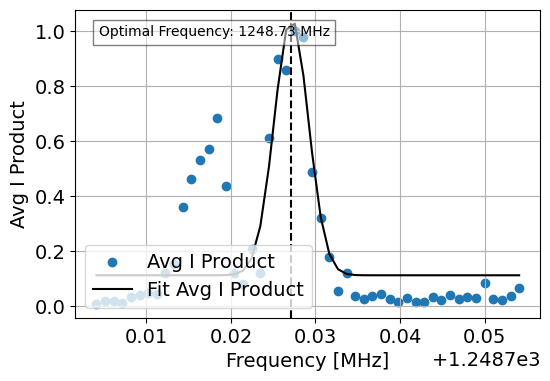

[JointParityCalibrator]     Optimal frequency: 1248.7271 MHz
[JointParityCalibrator]   Running error amp for qubit in |e>...
    Temporarily setting storage parameters: freq=1249.0115 MHz, gain=11615, pi_length=1.9859 us
storage is:  M1-S6
Job submitted: JOB-20260219-00757 (queue position: 1)

[0.1s] Job JOB-20260219-00757: pending

[2.2s] Job JOB-20260219-00757: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00757_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'man_mode_no': 1, 'stor_

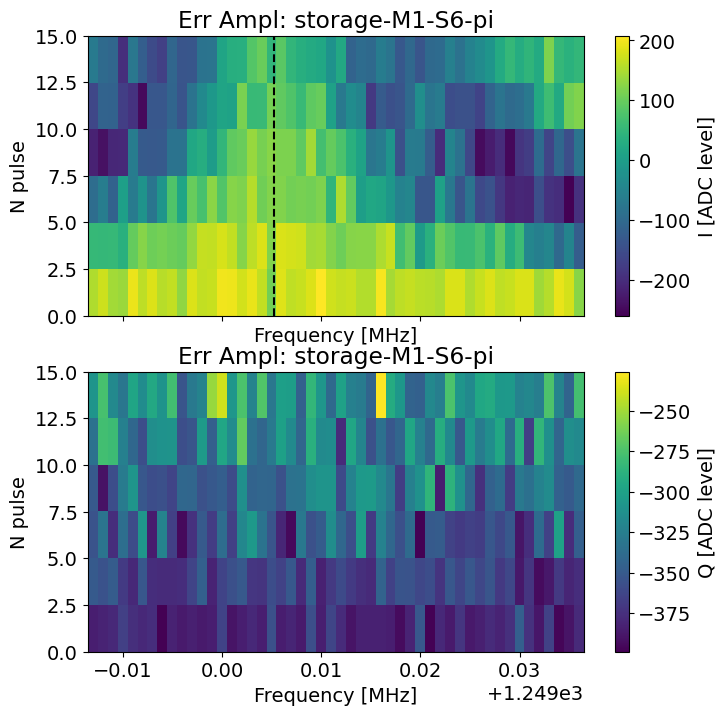

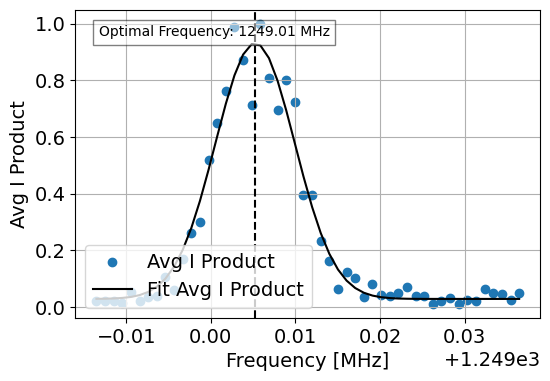

[JointParityCalibrator]     Optimal frequency: 1249.0052 MHz
[JointParityCalibrator]   Calibrated freq_bs=1248.8662 MHz
[JointParityCalibrator]   Running Rabi confirmation (run_both_states=False)...
Job submitted: JOB-20260219-00758 (queue position: 1)

[0.1s] Job JOB-20260219-00758: pending

[2.2s] Job JOB-20260219-00758: running
[WORKER] Loading SidebandGeneralExperiment from experiments.single_qubit.sideband_general
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00758_SidebandGeneralExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
100%|████████████████████████████████████████| 100/100 [00:39<00:00,  2.56it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00758_SidebandGeneralExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260219-00758_expt.pkl

[47.4s] Job JOB-20260219-00758: completed

Job completed

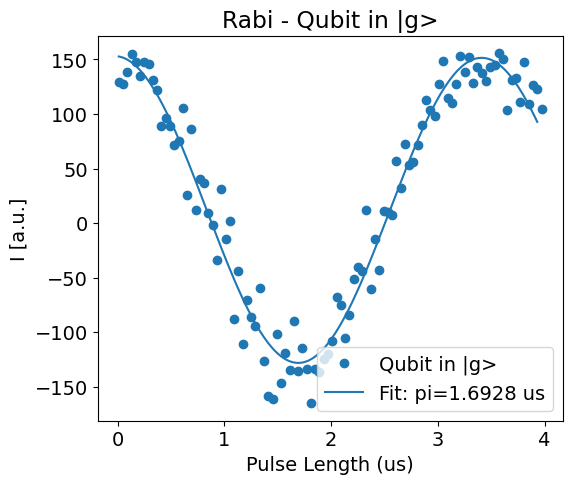

[JointParityCalibrator]     Extracted pi_length: 1.6928 us
[JointParityCalibrator]   Calibrated pi_length=1.6928 us
[JointParityCalibrator]   Running ALICE Wigner for qubit in |g>...
Job submitted: JOB-20260219-00759 (queue position: 1)

[0.1s] Job JOB-20260219-00759: pending

[2.2s] Job JOB-20260219-00759: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00759_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 56%|███████████████████████▌                  | 28/50 [00:11<00:08,  2.55it/s]
[46.9s] Job JOB-20260219-00759: completed
 56%|███████████████████████▌                  | 28/50 [00:11<00:08,  2.55it/s]
Job completed! Data: D:\experiments\250119_qec\data\JOB-20260219-00759_WignerTomography1ModeExperiment.h5


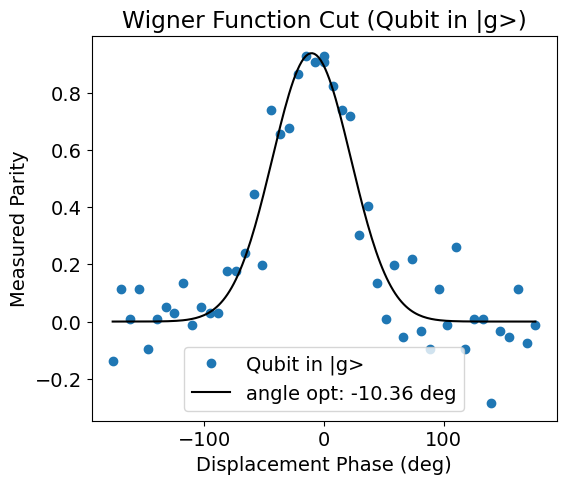

[JointParityCalibrator]     Theta: -10.36 deg
[JointParityCalibrator]   Running ALICE Wigner for qubit in |e>...
Job submitted: JOB-20260219-00761 (queue position: 1)

[0.1s] Job JOB-20260219-00761: pending

[25.8s] Job JOB-20260219-00761: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00761_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 96%|████████████████████████████████████████▎ | 48/50 [00:19<00:00,  2.56it/s]
[70.8s] Job JOB-20260219-00761: completed
100%|██████████████████████████████████████████| 50/50 [00:20<00:00,  2.42it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00761_WignerTomography1ModeExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260219-0076

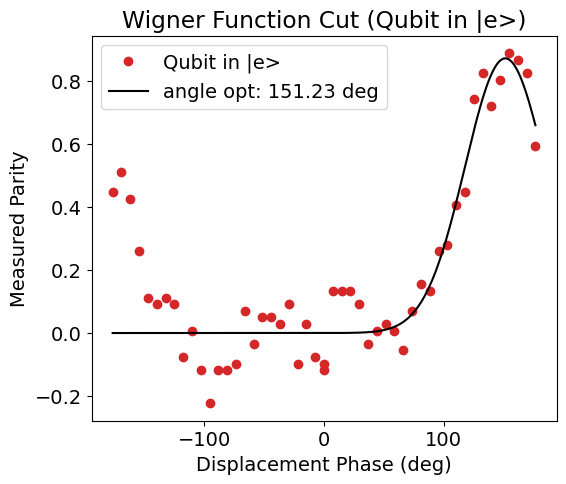

[JointParityCalibrator]     Theta: 151.23 deg
[JointParityCalibrator]   theta_g=-10.36 deg, theta_e=151.23 deg
[JointParityCalibrator]   Phase difference: 0.8977 pi
[JointParityCalibrator] 
Rate 3/5: g_bs=0.1304 MHz
[JointParityCalibrator] === ALICE: Calibrating at g_bs=0.1304 MHz ===
[JointParityCalibrator]   Initial: gain=12024, length_bs=1.9166 us
[JointParityCalibrator]   Freq guesses: f_bs_g=1248.7271, f_bs_e=1249.0052 (override=yes)
[JointParityCalibrator]   Running error amp for qubit in |g>...
    Temporarily setting storage parameters: freq=1248.7271 MHz, gain=12024, pi_length=1.9166 us
storage is:  M1-S6
Job submitted: JOB-20260219-00763 (queue position: 1)

[0.1s] Job JOB-20260219-00763: pending

[24.5s] Job JOB-20260219-00763: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00763_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORK

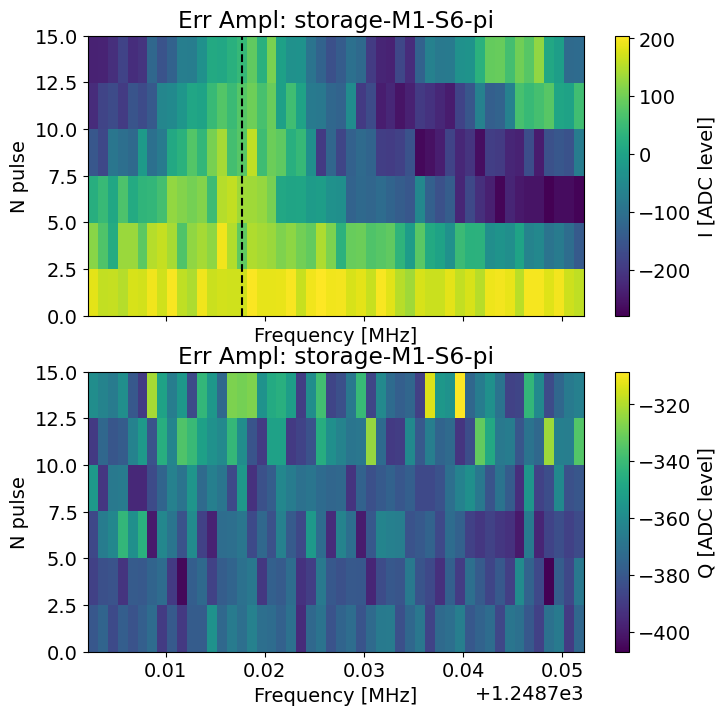

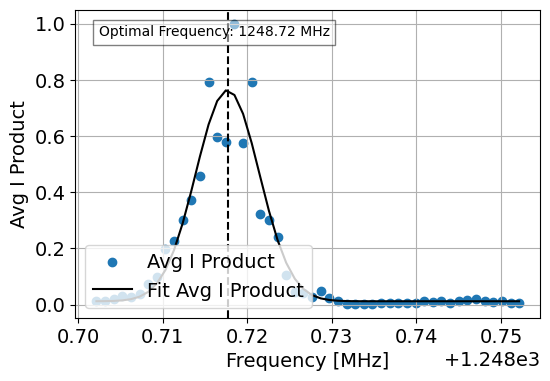

[JointParityCalibrator]     Optimal frequency: 1248.7177 MHz
[JointParityCalibrator]   Running error amp for qubit in |e>...
    Temporarily setting storage parameters: freq=1249.0052 MHz, gain=12024, pi_length=1.9166 us
storage is:  M1-S6
Job submitted: JOB-20260219-00764 (queue position: 1)

[0.1s] Job JOB-20260219-00764: pending

[2.1s] Job JOB-20260219-00764: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00764_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'man_mode_no': 1, 'stor_

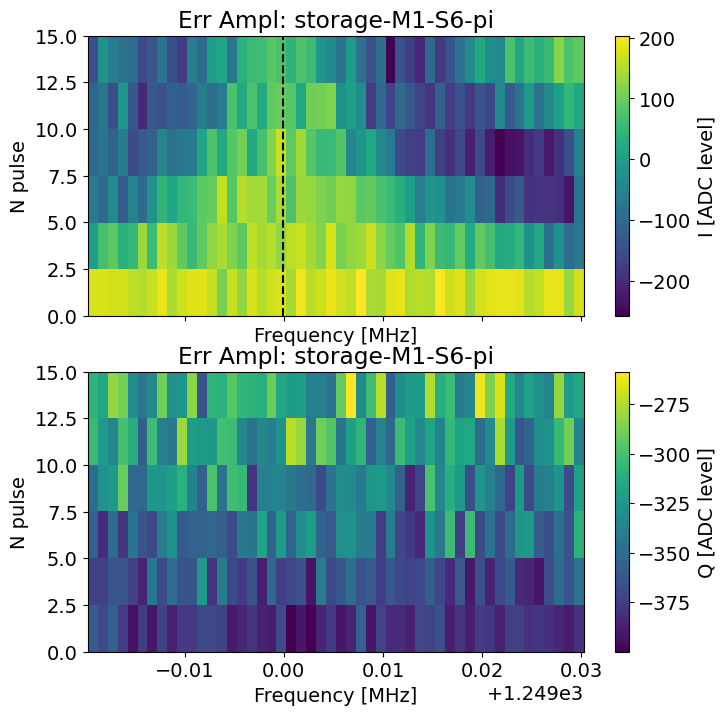

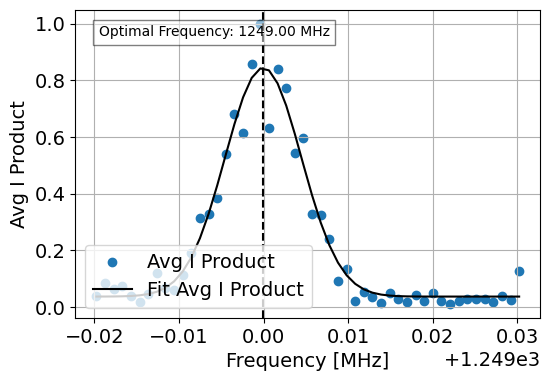

[JointParityCalibrator]     Optimal frequency: 1249.0000 MHz
[JointParityCalibrator]   Calibrated freq_bs=1248.8588 MHz
[JointParityCalibrator]   Running Rabi confirmation (run_both_states=False)...
Job submitted: JOB-20260219-00765 (queue position: 1)

[0.2s] Job JOB-20260219-00765: running
[WORKER] Loading SidebandGeneralExperiment from experiments.single_qubit.sideband_general
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00765_SidebandGeneralExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 94%|██████████████████████████████████████▌  | 94/100 [00:36<00:02,  2.64it/s]Using RF channel: 1

[44.8s] Job JOB-20260219-00765: completed
100%|████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00765_SidebandGeneralExperiment.h5
[WORKER] Saving expt object to: D:\experiments\2501

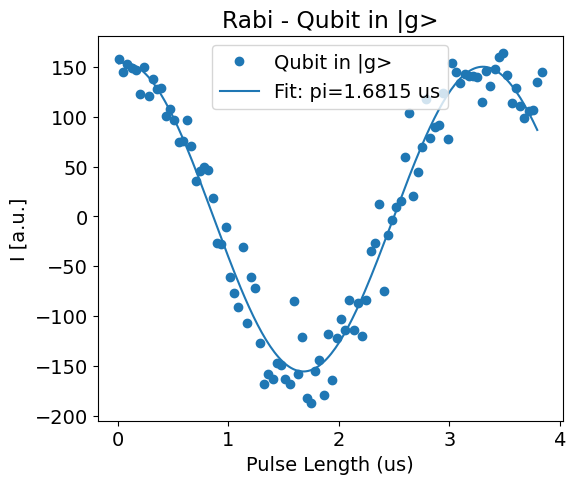

[JointParityCalibrator]     Extracted pi_length: 1.6815 us
[JointParityCalibrator]   Calibrated pi_length=1.6815 us
[JointParityCalibrator]   Running ALICE Wigner for qubit in |g>...
Job submitted: JOB-20260219-00766 (queue position: 1)

[0.1s] Job JOB-20260219-00766: pending

[2.1s] Job JOB-20260219-00766: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00766_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 90%|█████████████████████████████████████▊    | 45/50 [00:16<00:01,  2.71it/s]
[26.3s] Job JOB-20260219-00766: completed
100%|██████████████████████████████████████████| 50/50 [00:18<00:00,  2.66it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00766_WignerTomography1ModeExperiment.h5
[WORKER] Saving 

d:\python\multimode_expts\measurement_notebooks\QEC\joint_parity_calibrator.py:945: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, phases, parity, p0=p0)
d:\python\multimode_expts\measurement_notebooks\QEC\joint_parity_calibrator.py:150: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, phases_deg, parity, p0=p0)


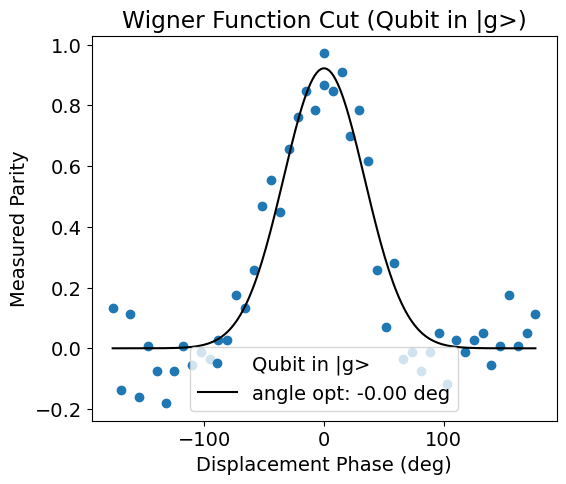

[JointParityCalibrator]     Theta: -0.00 deg
[JointParityCalibrator]   Running ALICE Wigner for qubit in |e>...
Job submitted: JOB-20260219-00767 (queue position: 1)

[0.1s] Job JOB-20260219-00767: pending

[2.1s] Job JOB-20260219-00767: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00767_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 92%|██████████████████████████████████████▋   | 46/50 [00:18<00:01,  2.62it/s]
[26.4s] Job JOB-20260219-00767: completed
100%|██████████████████████████████████████████| 50/50 [00:19<00:00,  2.55it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00767_WignerTomography1ModeExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260219-00767_

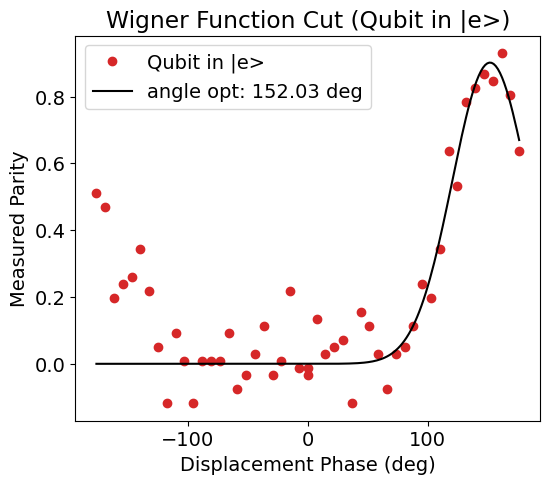

[JointParityCalibrator]     Theta: 152.03 deg
[JointParityCalibrator]   theta_g=-0.00 deg, theta_e=152.03 deg
[JointParityCalibrator]   Phase difference: 0.8446 pi
[JointParityCalibrator] 
Rate 4/5: g_bs=0.1350 MHz
[JointParityCalibrator] === ALICE: Calibrating at g_bs=0.1350 MHz ===
[JointParityCalibrator]   Initial: gain=12431, length_bs=1.8520 us
[JointParityCalibrator]   Freq guesses: f_bs_g=1248.7177, f_bs_e=1249.0000 (override=yes)
[JointParityCalibrator]   Running error amp for qubit in |g>...
    Temporarily setting storage parameters: freq=1248.7177 MHz, gain=12431, pi_length=1.8520 us
storage is:  M1-S6
Job submitted: JOB-20260219-00769 (queue position: 1)

[0.1s] Job JOB-20260219-00769: pending

[119.5s] Job JOB-20260219-00769: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00769_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORK

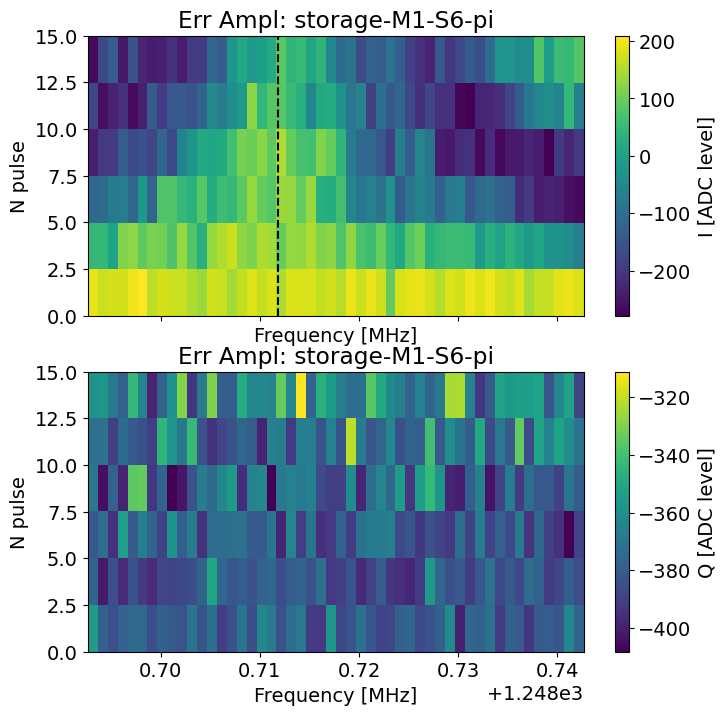

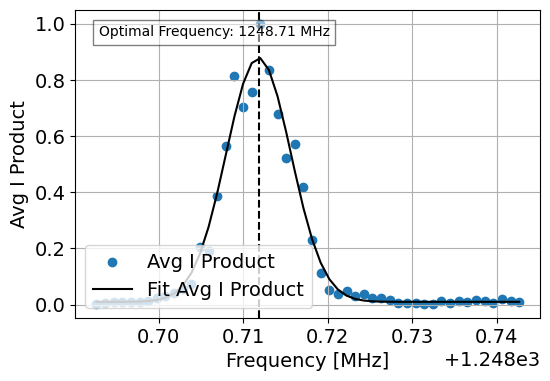

[JointParityCalibrator]     Optimal frequency: 1248.7118 MHz
[JointParityCalibrator]   Running error amp for qubit in |e>...
    Temporarily setting storage parameters: freq=1249.0000 MHz, gain=12431, pi_length=1.8520 us
storage is:  M1-S6
Job submitted: JOB-20260219-00771 (queue position: 1)

[0.1s] Job JOB-20260219-00771: pending

[120.5s] Job JOB-20260219-00771: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00771_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'man_mode_no': 1, 'sto

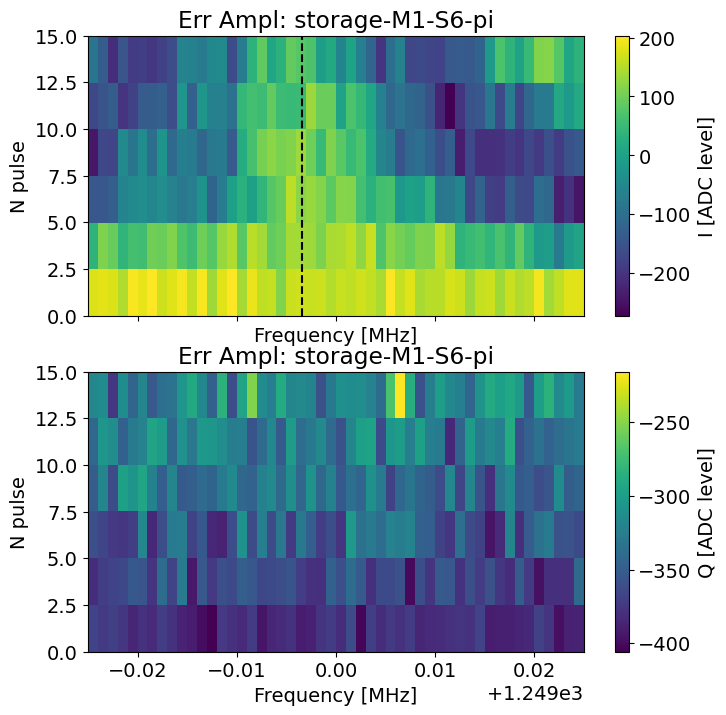

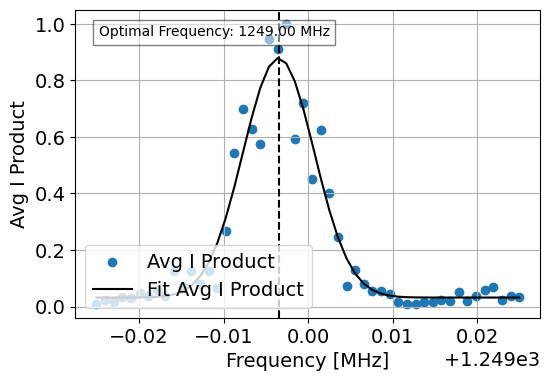

[JointParityCalibrator]     Optimal frequency: 1248.9965 MHz
[JointParityCalibrator]   Calibrated freq_bs=1248.8542 MHz
[JointParityCalibrator]   Running Rabi confirmation (run_both_states=False)...
Job submitted: JOB-20260219-00773 (queue position: 1)

[0.1s] Job JOB-20260219-00773: pending

[119.4s] Job JOB-20260219-00773: running
[WORKER] Loading SidebandGeneralExperiment from experiments.single_qubit.sideband_general
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00773_SidebandGeneralExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 95%|██████████████████████████████████████▉  | 95/100 [00:37<00:01,  2.52it/s]Using RF channel: 1

[182.2s] Job JOB-20260219-00773: completed
100%|████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00773_SidebandGeneralExperiment.h5
[WORKER]

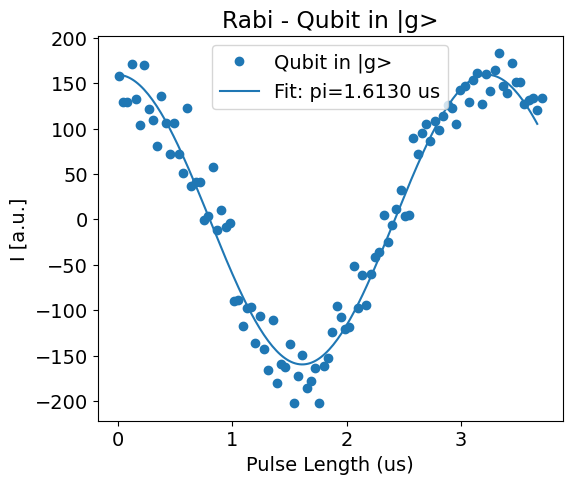

[JointParityCalibrator]     Extracted pi_length: 1.6130 us
[JointParityCalibrator]   Calibrated pi_length=1.6130 us
[JointParityCalibrator]   Running ALICE Wigner for qubit in |g>...
Job submitted: JOB-20260219-00775 (queue position: 1)

[0.1s] Job JOB-20260219-00775: pending

[121.7s] Job JOB-20260219-00775: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00775_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|█████████████████████████████████████████▏| 49/50 [00:19<00:00,  2.68it/s]
[164.3s] Job JOB-20260219-00775: completed
100%|██████████████████████████████████████████| 50/50 [00:19<00:00,  2.53it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00775_WignerTomography1ModeExperiment.h5
[WORKER] Savi

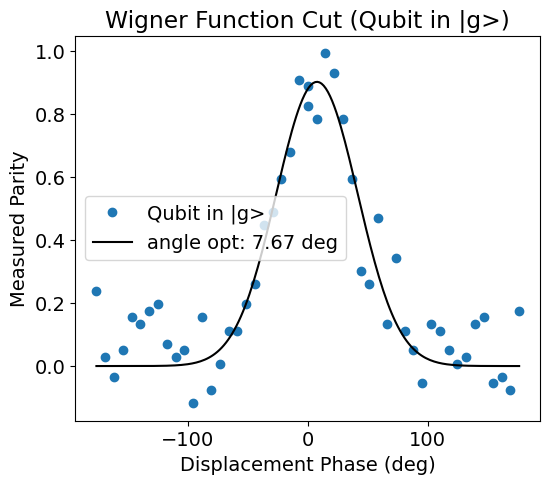

[JointParityCalibrator]     Theta: 7.67 deg
[JointParityCalibrator]   Running ALICE Wigner for qubit in |e>...
Job submitted: JOB-20260219-00777 (queue position: 1)

[0.1s] Job JOB-20260219-00777: pending

[119.2s] Job JOB-20260219-00777: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00777_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 98%|█████████████████████████████████████████▏| 49/50 [00:19<00:00,  2.63it/s]
[163.8s] Job JOB-20260219-00777: completed
100%|██████████████████████████████████████████| 50/50 [00:19<00:00,  2.54it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00777_WignerTomography1ModeExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260219-0077

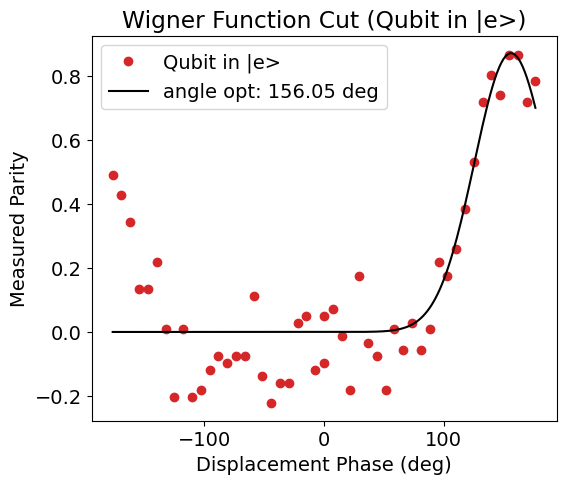

[JointParityCalibrator]     Theta: 156.05 deg
[JointParityCalibrator]   theta_g=7.67 deg, theta_e=156.05 deg
[JointParityCalibrator]   Phase difference: 0.8243 pi
[JointParityCalibrator] 
Rate 5/5: g_bs=0.1395 MHz
[JointParityCalibrator] === ALICE: Calibrating at g_bs=0.1395 MHz ===
[JointParityCalibrator]   Initial: gain=12825, length_bs=1.7916 us
[JointParityCalibrator]   Freq guesses: f_bs_g=1248.7118, f_bs_e=1248.9965 (override=yes)
[JointParityCalibrator]   Running error amp for qubit in |g>...
    Temporarily setting storage parameters: freq=1248.7118 MHz, gain=12825, pi_length=1.7916 us
storage is:  M1-S6
Job submitted: JOB-20260219-00779 (queue position: 1)

[0.1s] Job JOB-20260219-00779: pending

[117.4s] Job JOB-20260219-00779: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00779_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKE

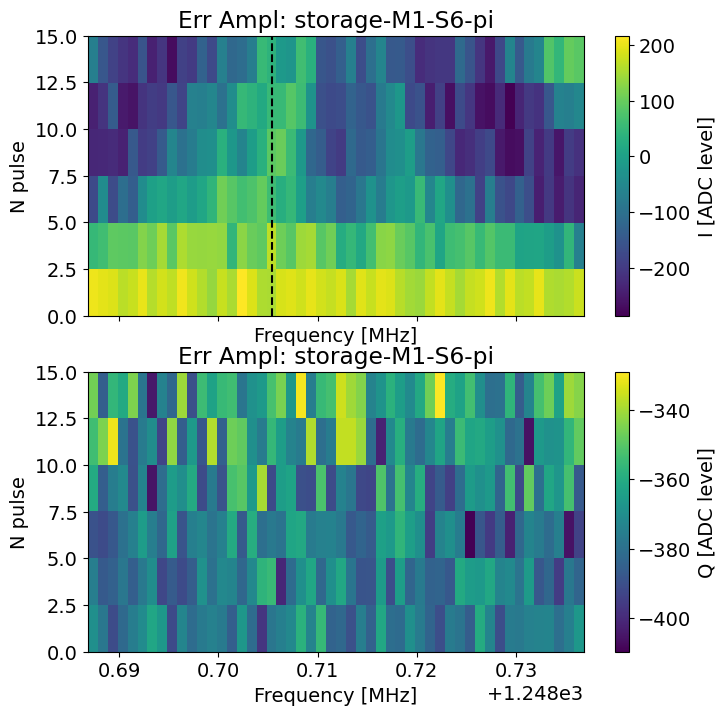

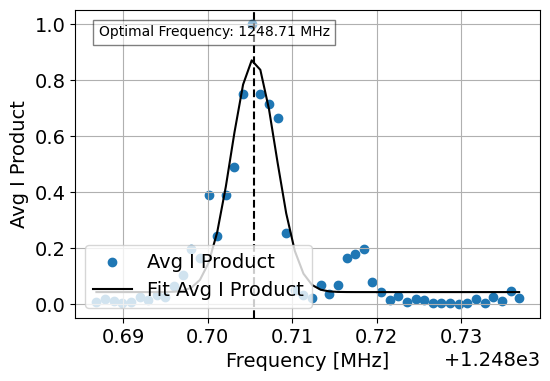

[JointParityCalibrator]     Optimal frequency: 1248.7054 MHz
[JointParityCalibrator]   Running error amp for qubit in |e>...
    Temporarily setting storage parameters: freq=1248.9965 MHz, gain=12825, pi_length=1.7916 us
storage is:  M1-S6
Job submitted: JOB-20260219-00780 (queue position: 1)

[0.1s] Job JOB-20260219-00780: pending

[2.1s] Job JOB-20260219-00780: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00780_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'man_mode_no': 1, 'stor_

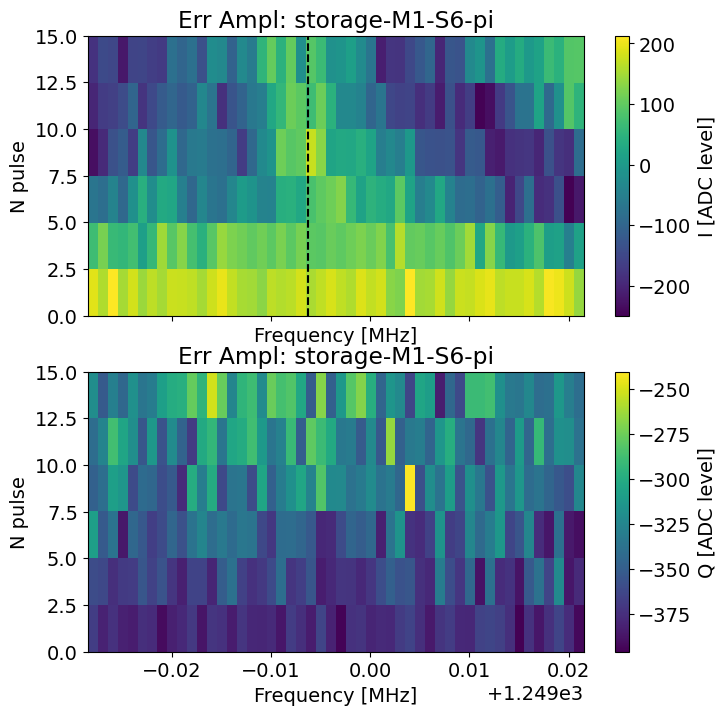

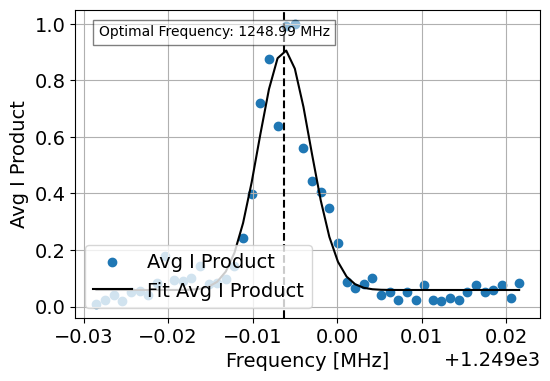

[JointParityCalibrator]     Optimal frequency: 1248.9938 MHz
[JointParityCalibrator]   Calibrated freq_bs=1248.8496 MHz
[JointParityCalibrator]   Running Rabi confirmation (run_both_states=False)...
Job submitted: JOB-20260219-00781 (queue position: 1)

[0.1s] Job JOB-20260219-00781: pending

[2.1s] Job JOB-20260219-00781: running
[WORKER] Loading SidebandGeneralExperiment from experiments.single_qubit.sideband_general
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00781_SidebandGeneralExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 99%|████████████████████████████████████████▌| 99/100 [00:39<00:00,  2.60it/s]Using RF channel: 1

[46.9s] Job JOB-20260219-00781: completed
100%|████████████████████████████████████████| 100/100 [00:39<00:00,  2.54it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00781_SidebandGeneralExperiment.h5
[WORKER] Sa

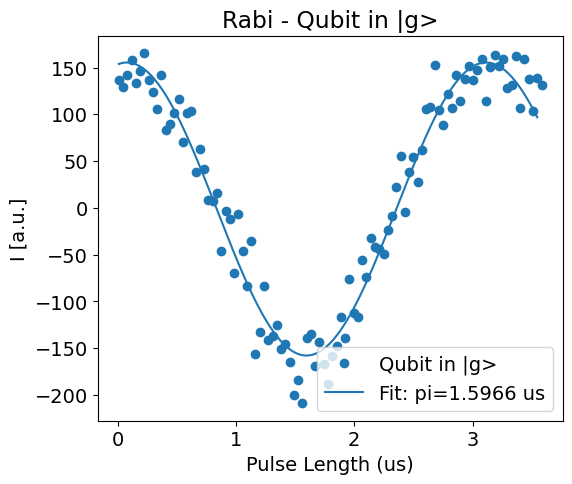

[JointParityCalibrator]     Extracted pi_length: 1.5966 us
[JointParityCalibrator]   Calibrated pi_length=1.5966 us
[JointParityCalibrator]   Running ALICE Wigner for qubit in |g>...
Job submitted: JOB-20260219-00782 (queue position: 1)

[0.1s] Job JOB-20260219-00782: pending

[2.3s] Job JOB-20260219-00782: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00782_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 92%|██████████████████████████████████████▋   | 46/50 [00:18<00:01,  2.67it/s]
[28.5s] Job JOB-20260219-00782: completed
100%|██████████████████████████████████████████| 50/50 [00:20<00:00,  2.41it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00782_WignerTomography1ModeExperiment.h5
[WORKER] Saving 

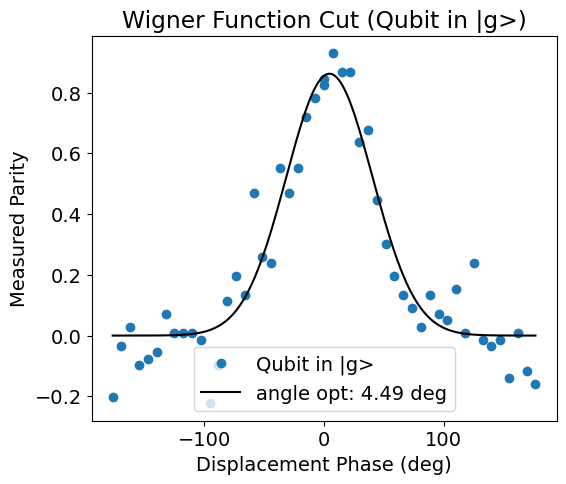

[JointParityCalibrator]     Theta: 4.49 deg
[JointParityCalibrator]   Running ALICE Wigner for qubit in |e>...
Job submitted: JOB-20260219-00783 (queue position: 1)

[0.1s] Job JOB-20260219-00783: pending

[2.1s] Job JOB-20260219-00783: running
[WORKER] Loading WignerTomography1ModeExperiment from experiments.qubit_cavity.single_mode_wigner_tomography
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00783_WignerTomography1ModeExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
100%|██████████████████████████████████████████| 50/50 [00:20<00:00,  2.46it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00783_WignerTomography1ModeExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260219-00783_expt.pkl

[28.6s] Job JOB-20260219-00783: completed

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260219-00783

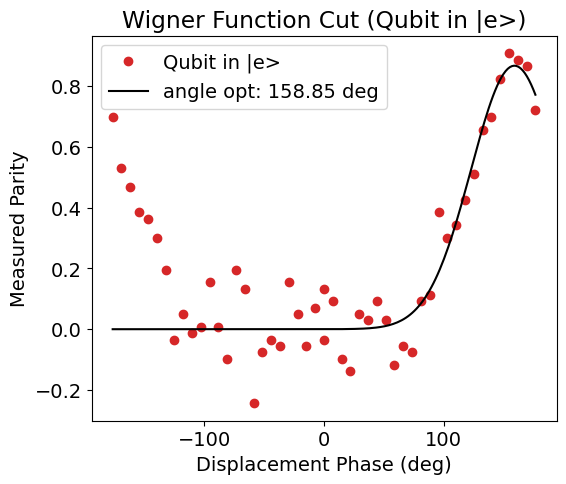

[JointParityCalibrator]     Theta: 158.85 deg
[JointParityCalibrator]   theta_g=4.49 deg, theta_e=158.85 deg
[JointParityCalibrator]   Phase difference: 0.8576 pi
[JointParityCalibrator] 
Best measured rate: 0.1213 MHz (phase_diff=0.9154 pi)
[JointParityCalibrator] 
Polynomial fit (degree 3): coeffs = [ 78661.67639651 -30316.45155453   3884.07547825   -164.5484759 ]
[JointParityCalibrator] Fitted optimal rate: 0.1440 MHz


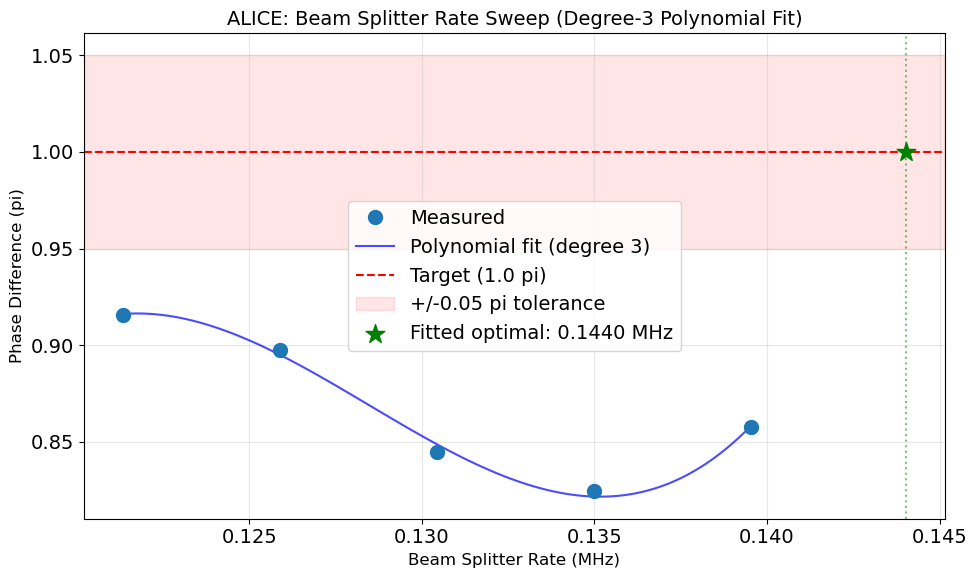

[JointParityCalibrator] 
=== Calibrating at fitted optimal rate: 0.1440 MHz ===
[JointParityCalibrator]   Using freq guess from closest sweep point (g_bs=0.1395 MHz): f_bs_g=1248.7054, f_bs_e=1248.9938
[JointParityCalibrator]   Initial: gain=13202, length_bs=1.7358 us
[JointParityCalibrator]   Running error amp for qubit in |g>...
    Temporarily setting storage parameters: freq=1248.7054 MHz, gain=13202, pi_length=1.7358 us
storage is:  M1-S6
Job submitted: JOB-20260219-00784 (queue position: 1)

[0.1s] Job JOB-20260219-00784: pending

[2.3s] Job JOB-20260219-00784: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00784_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0,

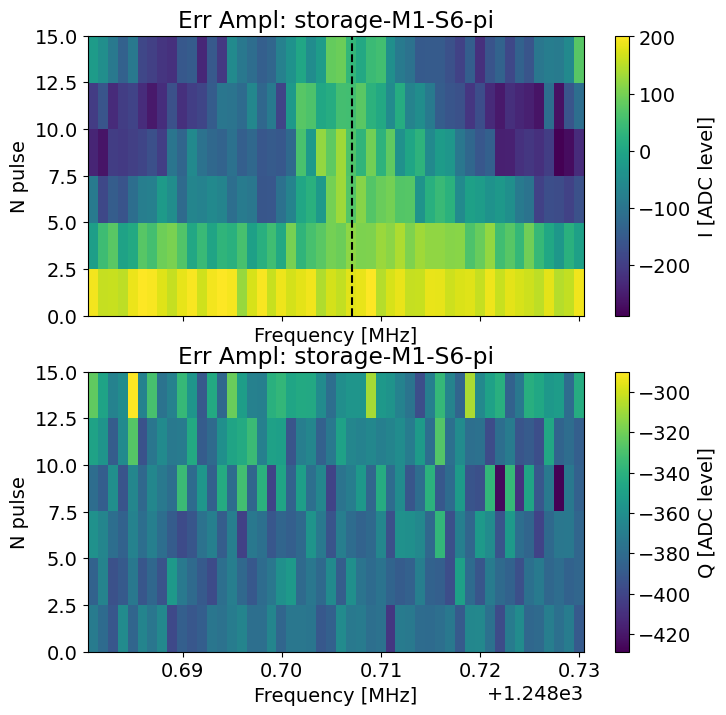

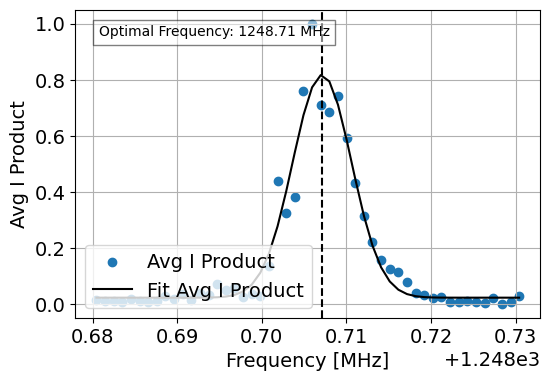

[JointParityCalibrator]     Optimal frequency: 1248.7071 MHz
[JointParityCalibrator]   Running error amp for qubit in |e>...
    Temporarily setting storage parameters: freq=1248.9938 MHz, gain=13202, pi_length=1.7358 us
storage is:  M1-S6
Job submitted: JOB-20260219-00785 (queue position: 1)

[0.1s] Job JOB-20260219-00785: pending

[2.1s] Job JOB-20260219-00785: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00785_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'man_mode_no': 1, 'stor_

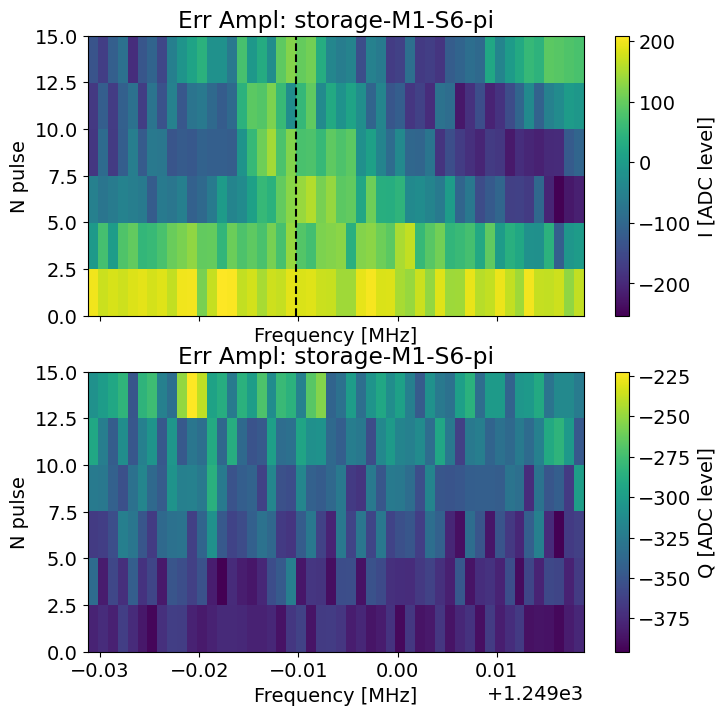

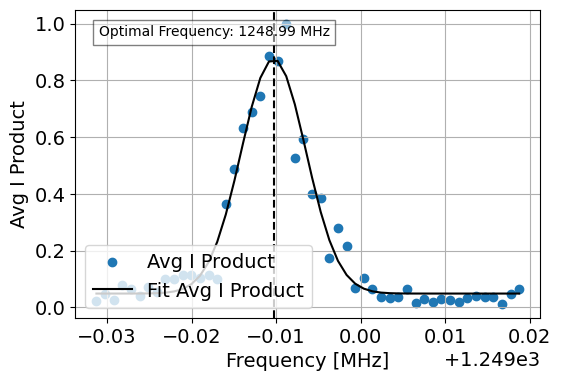

[JointParityCalibrator]     Optimal frequency: 1248.9897 MHz
[JointParityCalibrator]   Calibrated freq_bs=1248.8484 MHz
[JointParityCalibrator]   Running Rabi confirmation (run_both_states=False)...
Job submitted: JOB-20260219-00786 (queue position: 1)

[0.2s] Job JOB-20260219-00786: pending

[2.2s] Job JOB-20260219-00786: running
[WORKER] Loading SidebandGeneralExperiment from experiments.single_qubit.sideband_general
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260219-00786_SidebandGeneralExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 97%|███████████████████████████████████████▊ | 97/100 [01:27<00:02,  1.12it/s]Using RF channel: 1

[96.5s] Job JOB-20260219-00786: completed
100%|████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]
Saving D:\experiments\250119_qec\data\JOB-20260219-00786_SidebandGeneralExperiment.h5
[WORKER] Sa

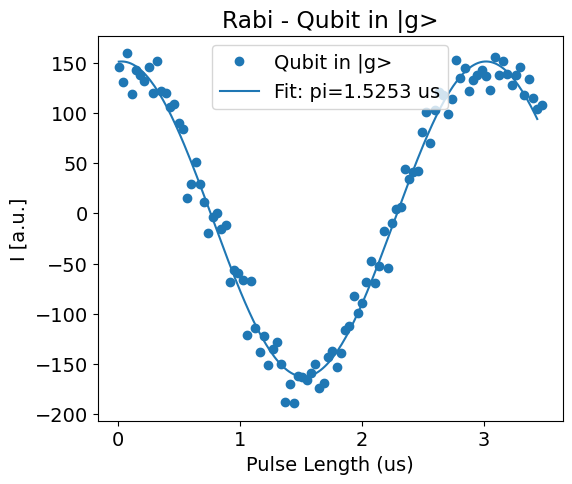

[JointParityCalibrator]     Extracted pi_length: 1.5253 us
[JointParityCalibrator]   Calibrated pi_length=1.5253 us


In [ ]:
mode_to_test = [2, 6, 1]
alice_result_list = []
bob_result_list = []

for stor_mode_no in mode_to_test:
    stor_name = f'M1-S{stor_mode_no}'

    alice_result = calibrator.sweep_beam_splitter_rate(
        rate_list,
        alpha_amplitude=.3,
        target_phase_tol=0.05,
        target_phase_diff=1.0,
        # wigner_n_points=100, 
        wigner_n_points=50,
        fit_degree=3,
        stor_mode_no=stor_mode_no,
    )

    wait_time_list = alice_result['fitted_calibration']['pi_length'] * np.linspace(0.95, 1.15, 15) * 2
    bob_result = calibrator.calibrate_wait_time(
        wait_time_list,
        fixed_params=alice_result['fitted_calibration'],
        wigner_n_points=100, 
        fit_degree=3,
        target_phase_diff=1.,
        target_phase_tol=0.05,
        alpha_amplitude=.3,

    )

    freq_bs = alice_result['fitted_calibration']['freq_bs']
    gain = alice_result['fitted_calibration']['gain']
    pi_length = alice_result['fitted_calibration']['pi_length']
    wait_time = bob_result['fitted_optimal_wait'] 

    print(f"Final fitted parameters for storage mode S{stor_mode_no}:")
    print(f"Beam-splitter frequency: {freq_bs:.4f} MHz")
    print(f"Beam-splitter gain: {gain:.2f}")
    print(f"Pi pulse length: {pi_length:.4f} us")
    print(f"Optimal wait time: {wait_time:.4f} us")

    station.ds_storage.update_joint_parity(
    stor_name=stor_name,
    freq_bs=freq_bs,
    gain=gain,
    length=pi_length * 2,
    wait_time=wait_time
    )
    print(f"Stored joint parity params for {stor_name}: freq={freq_bs:.4f} MHz, gain={gain}, length={pi_length*2:.4f} us, wait_time={wait_time} us")

    # Optionally snapshot to save to config version
    station.snapshot_man1_storage_swap(update_main=True)

    

In [ ]:
# alice_result['fitted_calibration'] = alice_result['optimal_result']

In [ ]:
wait_time_list = alice_result['fitted_calibration']['pi_length'] * np.linspace(0.95, 1.1, 9) * 2
bob_result = calibrator.calibrate_wait_time(
    wait_time_list,
    fixed_params=alice_result['fitted_calibration'],
    wigner_n_points=100, 
    fit_degree=3,
    target_phase_diff=1.,
    target_phase_tol=0.05,
    alpha_amplitude=.3,

)

In [ ]:
bob_result.keys()
bob_result['fitted_optimal_wait']

In [ ]:
freq_bs = alice_result['fitted_calibration']['freq_bs']
gain = alice_result['fitted_calibration']['gain']
pi_length = alice_result['fitted_calibration']['pi_length']
wait_time = bob_result['fitted_optimal_wait'] 

In [ ]:
station.ds_storage.update_joint_parity(
    stor_name=stor_name,
    freq_bs=freq_bs,
    gain=gain,
    length=pi_length * 2,
    wait_time=wait_time
)
print(f"Stored joint parity params for {stor_name}: freq={freq_bs:.4f} MHz, gain={gain}, length={pi_length*2:.4f} us, wait_time={wait_time} us")

# Optionally snapshot to save to config version
station.snapshot_man1_storage_swap(update_main=True)
# station.preview_config_update()

## Check the joint parity measurement

In [ ]:
# 1. Define defaults
parity_phase_defaults = AttrDict(dict(
    # Phase sweep parameters
    start=0,
    step=3.6,  # 100 points over 360 degrees
    expts=100,
    # Averaging
    reps=200,
    rounds=1,
    # Storage modes
    storage_swap=3,      # M1-S3 - swapped to/from manipulate
    storage_parity=1,    # M1-S1 - probed by joint parity (NOT swapped)
    manipulate=1,
    # State preparation: '00', '10', '01', or '11'
    state_start='00',
    # Pulse mode
    parity_fast=True,
    # Reset options
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    # Optional prepulse
    prepulse=False,
    gate_based=False,
    # Qubit selection
    qubits=[0],
    relax_delay=2500,
))


# 2. Optional postprocessor (extract results, update config)
def parity_phase_postproc(station, expt):
    # Example: extract fitted phase offset if needed
    if 'fit_avgi' in expt.data:
        phase_offset = expt.data['fit_avgi'][2]  # phase parameter from sin fit
        print(f"Fitted phase offset: {phase_offset:.2f} deg")
    return None

# 3. Create the runner
parity_phase_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityPhaseExperiment,
    default_expt_cfg=parity_phase_defaults,
    postprocessor=parity_phase_postproc,  # optional
    job_client=client,
    use_queue=USE_QUEUE,
)




In [ ]:
# 5. Execute with optional overrides
parity_phase_expt = parity_phase_runner.execute(
    # Override any defaults via kwargs:
    # storage_swap=3,
    # storage_parity=1,
    storage_swap=4,
    storage_parity=2,

    state_start=['10', '01', '00', '11'],  # '00', '10', '01', or '11'
    reps=100,
    go_kwargs=dict(analyze=True, display=True),
    parity_fast=False,
    **active_reset_dict,
)

# If using queue, display results manually
if USE_QUEUE:
    parity_phase_expt.analyze()
    parity_phase_expt.display()

In [ ]:
# ============================================
# Dual Rail Sandbox Experiment
# ============================================

# 1. Define defaults
dual_rail_sandbox_defaults = AttrDict(dict(
    # Averaging
    reps=500,
    rounds=1,
    # Storage modes for dual rail
    storage_1=1,             # First storage mode (e.g., S1)
    storage_2=3,             # Second storage mode (e.g., S3)
    manipulate=1,            # Manipulate mode
    # State preparation: '00', '10', '01', '11' or list
    state_start='00',
    # Wait and parity options
    wait_time=0,             # Wait time in us (0 = skip)
    repeat_count=1,          # Number of (wait + joint_parity) loops
    parity_flag=False,       # If True, measure joint parity during repeat
    parity_fast=False,       # If True, use fast multiphoton hpi pulses
    # Reset options
    active_reset=False,
    reset_before_dual_rail=False,
    reset_after_dual_rail=False,
    # Qubit selection
    qubits=[0],
    relax_delay=10000,
))


# 2. Optional postprocessor
def dual_rail_sandbox_postproc(station, expt):
    """Post-process dual rail sandbox results."""
    # Analyze with post-selection
    expt.analyze(post_select=True)
    
    # Print summary
    state_list = expt.data.get('states', ['00'])
    for state in state_list:
        pops = expt.data.get(f'pop_{state}', {})
        post_count = expt.data.get(f'post_select_count_{state}', expt.cfg.expt.reps)
        print(f"State |{state}>: 00={pops.get('00',0):.3f}, 10={pops.get('10',0):.3f}, "
              f"01={pops.get('01',0):.3f}, 11={pops.get('11',0):.3f} "
              f"(post-sel: {post_count}/{expt.cfg.expt.reps})")
    return None


# 3. Create the runner
dual_rail_sandbox_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.DualRailSandboxExperiment,
    default_expt_cfg=dual_rail_sandbox_defaults,
    postprocessor=dual_rail_sandbox_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)



In [ ]:
wait_list = np.arange(0, 6000+60, 60)
# wait_list = np.arange(0, 6000, 1000)
# wait_list = 0
print('wait_list:', wait_list)

In [ ]:
# storage_1 = [1, 4, 6]
# storage_2 = [3, 2, 7]

storage_1 = [6]
storage_2 = [7]



for s1, s2 in zip(storage_1, storage_2):

    single_shot = single_shot_runner.execute(
        go_kwargs=dict(analyze=False, display=False),
        check_f=False,
        relax_delay=2500,
        gate_based=False,
        # **active_reset_dict,
    )
    
    print(f"Testing storage modes: {s1} and {s2}")
    # 4. Execute - Basic state preparation test (no joint parity)
    dual_rail_expt = dual_rail_sandbox_runner.execute(
        state_start=['01', '10'],  # Logical states
        # state_start=['01'],  # Logical states
        storage_1=s1,
        storage_2=s2,
        wait_time=wait_list,
        parity_flag=False,
        reset_before_dual_rail=False,
        measure_parity=True,
        reps=10000,
        go_kwargs=dict(analyze=False, display=False),
        **active_reset_dict,
        prep_postselect=False, 
        prep_ps_parity=False,
    )

    # If using queue, analyze and display manually
    if USE_QUEUE:
        dual_rail_expt.analyze(post_select=False)
        dual_rail_expt.display(show_iq=False, show_histograms=False, log_scale=True)




In [ ]:
    # If using queue, analyze and display manually
if USE_QUEUE:
    dual_rail_expt.analyze(post_select=False)
    dual_rail_expt.display(show_iq=False, show_histograms=False, log_scale=True)



In [ ]:
# ============================================
# Dual Rail Ramsey Experiment
# ============================================

# from experiments.dual_rail.dual_rail_ramsey import DualRailRamseyExperiment

# 1. Define defaults
dual_rail_ramsey_defaults = AttrDict(dict(
    # Sweep parameters
    start=0.1,               # us, initial wait time
    step=0.5,                # us, wait time increment (Nyquist: 1/step > 2*ramsey_freq)
    expts=100,               # number of sweep points
    ramsey_freq=0.5,         # MHz, virtual detuning frequency
    # Averaging
    reps=250,
    rounds=1,
    # Storage modes for dual rail
    storage_1=1,             # First storage mode (e.g., S1)
    storage_2=3,             # Second storage mode (e.g., S3)
    manipulate=1,            # Manipulate mode
    # State preparation: '10', '01', or ['10', '01'] for both
    state_start='10',
    # Measurement options
    measure_parity=True,     # True for parity, False for slow pi
    reset_before_dual_rail=False,
    reset_after_dual_rail=False,
    # Reset options
    # **active_reset_dict,
    active_reset=False,
    # Qubit selection
    qubits=[0],
    relax_delay=2500,
))


# 2. Optional postprocessor
def dual_rail_ramsey_postproc(station, expt):
    """Post-process dual rail Ramsey results."""
    expt.analyze(fit=True)
    
    state_list = expt.data.get('states', ['10'])
    for state in state_list:
        fit_p1 = expt.data.get(f'fit_p1_{state}')
        if fit_p1 is not None:
            print(f"State |{state}>: T2 Ramsey = {fit_p1[3]:.4g} us, "
                  f"fit freq = {fit_p1[1]:.6g} MHz")
    return None


# 3. Create the runner
dual_rail_ramsey_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.DualRailRamseyExperiment,
    default_expt_cfg=dual_rail_ramsey_defaults,
    postprocessor=dual_rail_ramsey_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


In [ ]:
# 4. Execute

# f_ramsey = 0.067 # s6s7 echo and ramsey it seems 
# f_ramsey = 0 # s1s3 echo 
# f_ramsey = 0.0503 #s1s3 ramsey
# f_ramsey = 0.09428-0.02611# s2s4 ramsey


expt = 200 
reps = 10000
step = 15

# f_ramsey = [0, 0.09428, 0.09428-0.02611] # s1s3 ramsey, s2s4 ramsey
f_ramsey = [0, 0.09428+0.0123, 0.09428-0.02611] # s1s3 ramsey, s2s4 ramsey
storage_1 = [1, 4, 6]
storage_2 = [3, 2, 7]
echo = False
f_add = 0.002


for s1, s2, f in zip(storage_1[2:], storage_2[2:], f_ramsey[2:]):
    print(f"Running Dual Rail Ramsey for storage modes {s1} and {s2} with f_ramsey={f} MHz")


    dual_rail_ramsey_expt = dual_rail_ramsey_runner.execute(
        state_start=['10'],   # Run both logical states
        storage_1=s1,
        storage_2=s2,
        ramsey_freq=-f+f_add,           # MHz
        start=0.0001,
        step=step,
        expts=expt,
        reps=reps,
        echo=False,
        go_kwargs=dict(analyze=False, display=False),
        # **active_reset_dict,
    )

    # If using queue, analyze and display manually
    if USE_QUEUE:
        dual_rail_ramsey_expt.analyze(fit=True)
        dual_rail_ramsey_expt.display(fit=True, n_iq_panels=10, show_iq=False)



In [ ]:

expt = 200 
reps = 10000
step = 15

# f_ramsey = [0, 0.09428, 0.09428-0.02611] # s1s3 ramsey, s2s4 ramsey
f_ramsey = [0, 0.09428+0.0123, 0.09428-0.02611] # s1s3 ramsey, s2s4 ramsey
storage_1 = [1, 4, 6]
storage_2 = [3, 2, 7]
echo = False
f_add = 0.002


In [ ]:
for s1, s2, f in zip(storage_1[1:], storage_2[1:], f_ramsey[1:]):
    print(f"Running Dual Rail Ramsey for storage modes {s1} and {s2} with f_ramsey={f} MHz")


    dual_rail_ramsey_expt = dual_rail_ramsey_runner.execute(
        state_start=['10'],   # Run both logical states
        storage_1=s1,
        storage_2=s2,
        ramsey_freq=0.0015,           # MHz
        start=0.0001,
        step=step,
        expts=expt,
        reps=reps,
        echo=True,
        go_kwargs=dict(analyze=False, display=False),
        # **active_reset_dict,
    )

    # If using queue, analyze and display manually
    if USE_QUEUE:
        dual_rail_ramsey_expt.analyze(fit=True)
        dual_rail_ramsey_expt.display(fit=True, n_iq_panels=10, show_iq=False)


### T2 storages modes 

In [ ]:
# ============================================
# Cavity Mode T2 (Ramsey / Echo) - per-mode coherence
# ============================================

t2_cavity_mode_defaults = AttrDict(dict(
    start=0.01,
    step=0.02 * 50,
    expts=200,
    ramsey_freq=-5.55,
    reps=250,
    rounds=1,
    qubits=[0],
    mode='storage',          # 'storage', 'manipulate', or 'coupler'
    storage_mode_idx=1,      # for storage mode
    man_mode_no=1,           # manipulate mode to go through (for storage)
    man_mode_idx=1,          # for manipulate mode
    phase_on_flux=True,
    echoes=0,                # 0 = Ramsey, >0 = Echo
    parity_meas=True,
    active_reset=False,
    prepulse=False,
    postpulse=False,
    gate_based=True,
))


t2_cavity_mode_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.t2_cavity_mode.CavityModeRamseyExperiment,
    default_expt_cfg=t2_cavity_mode_defaults,
    job_client=client,
    use_queue=USE_QUEUE,
)


In [ ]:
storage_modes = [1, 3, 2, 4, 6, 7]

for s in storage_modes:
    print(f"Running Cavity Mode Ramsey for storage mode {s}")
    t2_mode = t2_cavity_mode_runner.execute(
        mode='storage',
        storage_mode_idx=s,
        man_mode_no=1,
        ramsey_freq=-5.55,
        go_kwargs=dict(analyze=True, display=True),
        **active_reset_dict,
    )

    if USE_QUEUE:
        t2_mode.analyze()
        t2_mode.display()
